# Improving Variational Quantum Optimization using CVaR

## Introduction

This notebook shows how to use the Conditional Value at Risk (CVaR) objective function introduced in [1] within the variational quantum optimization algorithms provided by [Qiskit Algorithms](https://qiskit-community.github.io/qiskit-algorithms/). Particularly, it is shown how to setup the `MinimumEigenOptimizer` using `SamplingVQE` accordingly.
For a given set of shots with corresponding objective values of the considered optimization problem, the CVaR with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots.
Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots, and $\alpha \in (0, 1)$ is a tradeoff between focusing on better shots, but still applying some averaging to smoothen the optimization landscape.


## References

[1] [P. Barkoutsos et al., *Improving Variational Quantum Optimization using CVaR,* Quantum 4, 256 (2020).](https://quantum-journal.org/papers/q-2020-04-20-256/)

## Qiskit Patterns
## Step 1: Mapping the classical problem to a problem that can be understood by a quantum computer.
In this tutorial, we map a Max-Cut problem with the following graph to a cost function Hamiltonian.

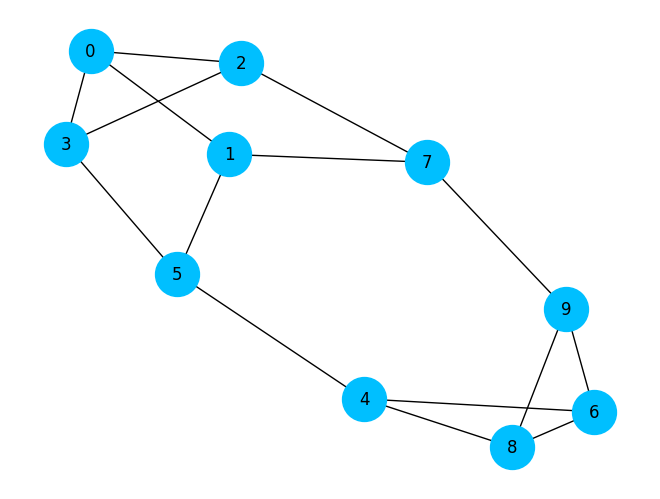

In [1]:
import networkx as nx

seed = 100
graph = nx.random_regular_graph(3, 10, seed=seed)
nx.draw(
    graph,
    with_labels=True,
    node_size=1000,
    node_color="deepskyblue",
    pos=nx.spring_layout(graph, seed=seed),
)

This graph has 10 nodes and 15 edges, and it can be encoded in 10 qubits.

In [2]:
num_qubits = len(graph.nodes)
print(num_qubits)

10


The following code allows you to easily construct the cost hamiltonian from a graph. You can find this utility function, along with other best practices for combinatorial optimization problems, in the [`qopt-best-practice`](https://github.com/qiskit-community/qopt-best-practices) repository.

In [4]:
def build_max_cut_paulis(graph: nx.Graph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in graph.edges():
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1]).get("weight", 1.0)

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
print(max_cut_paulis)

[('IIIIIIIIZZ', 1.0), ('IIIIIIZIIZ', 1.0), ('IIIIIIIZIZ', 1.0), ('IIIIZIIIZI', 1.0), ('IIZIIIIIZI', 1.0), ('IIZIIIIZII', 1.0), ('IIIIIIZZII', 1.0), ('ZIZIIIIIII', 1.0), ('IIIIZZIIII', 1.0), ('IIIIZIZIII', 1.0), ('IZIZIIIIII', 1.0), ('IIIZIZIIII', 1.0), ('ZIIZIIIIII', 1.0), ('ZZIIIIIIII', 1.0), ('IZIIIZIIII', 1.0)]


## Step 2: Building a quantum circuit from the problem and optimizing the quantum circuit for quantum execution.

### 2.1 Building a quantum circuit from the problem for the QAOA
The QAOA is a hybrid iterative method for solving combinatorial optimization problems. Please see this [tutorial](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) for a more detailed explanation of the QAOA.

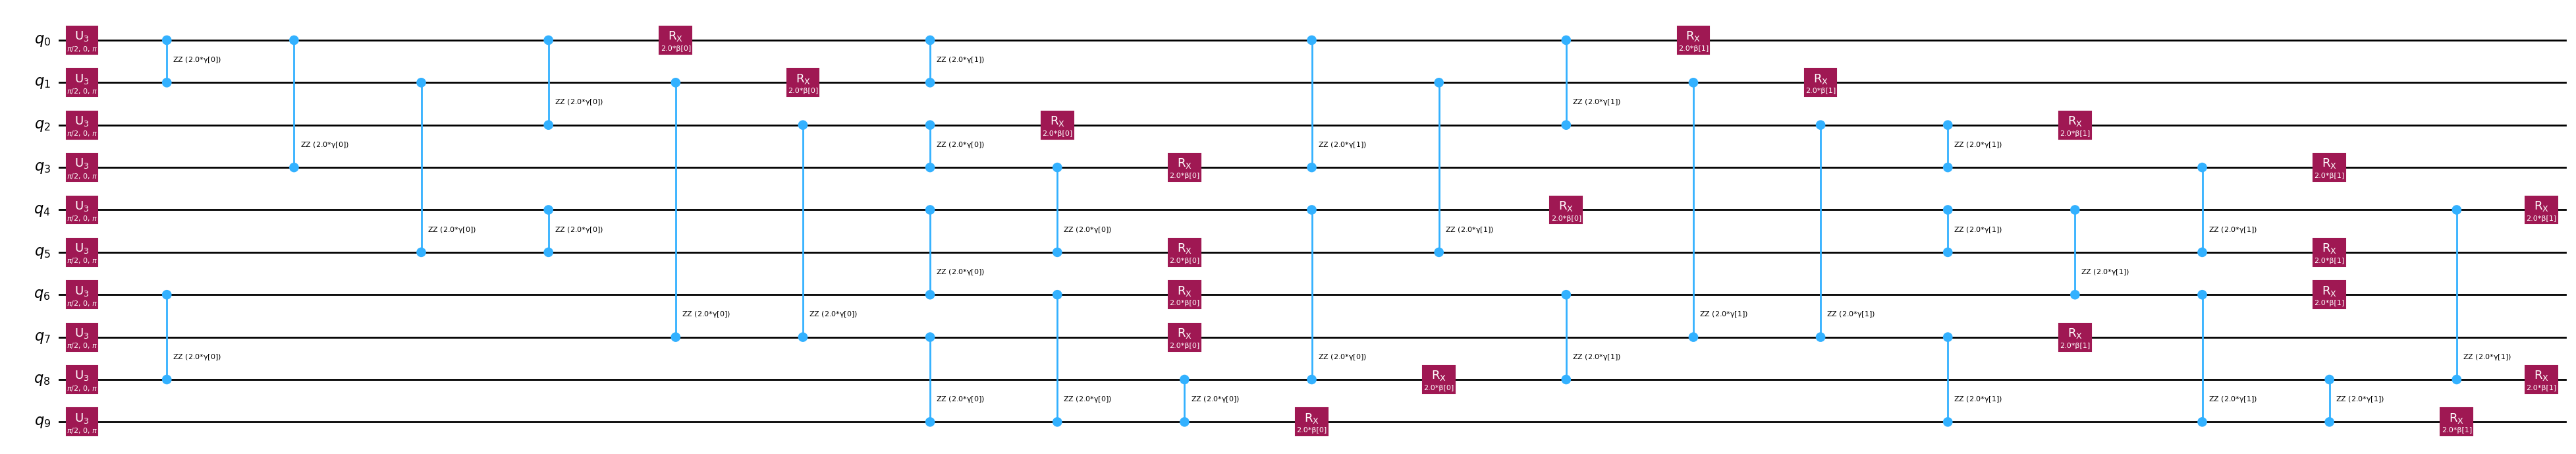

In [5]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

cost_operator = SparsePauliOp.from_list(max_cut_paulis)
ansatz = QAOAAnsatz(
    cost_operator,
    reps=2,
).decompose()
ansatz.decompose(reps=2).draw(output="mpl", fold=False)

### 2.2 Optimizing the quantum circuit for quantum execution
We use the SWAP strategy and the SAT mapping to optimize the quantum circuit. The detail of those techniques can be found in this [tutorial](./qaoa-transpiler.ipynb).



In [6]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line(list(range(num_qubits)))

In [7]:
"""A class to solve the SWAP gate insertion initial mapping problem
using the SAT approach from https://arxiv.org/abs/2212.05666.
"""

from __future__ import annotations

from dataclasses import dataclass
from itertools import combinations
from threading import Timer

import numpy as np

from pysat.formula import CNF, IDPool
from pysat.solvers import Solver


@dataclass
class SATResult:
    """A data class to hold the result of a SAT solver."""

    satisfiable: bool  # Satisfiable is True if the SAT model could be solved in a given time.
    solution: dict  # The solution to the SAT problem if it is satisfiable.
    mapping: list  # The mapping of nodes in the pattern graph to nodes in the target graph.
    elapsed_time: float  # The time it took to solve the SAT model.


class SATMapper:
    r"""A class to introduce a SAT-approach to solve
    the initial mapping problem in SWAP gate insertion for commuting gates.

    When this pass is run on a DAG it will look for the first instance of
    :class:`.Commuting2qBlock` and use the program graph :math:`P` of this block of gates to
    find a layout for a given swap strategy. This layout is found with a
    binary search over the layers :math:`l` of the swap strategy. At each considered layer
    a subgraph isomorphism problem formulated as a SAT is solved by a SAT solver. Each instance
    is whether it is possible to embed the program graph :math:`P` into the effective
    connectivity graph :math:`C_l` that is achieved by applying :math:`l` layers of the
    swap strategy to the coupling map :math:`C_0` of the backend. Since solving SAT problems
    can be hard, a ``time_out`` fixes the maximum time allotted to the SAT solver for each
    instance. If this time is exceeded the considered problem is deemed unsatisfiable and
    the binary search proceeds to the next number of swap layers :math:``l``.
    """

    def __init__(self, timeout: int = 60):
        """Initialize the SATMapping.

        Args:
            timeout: The allowed time in seconds for each iteration of the SAT solver. This
                variable defaults to 60 seconds.
        """
        self.timeout = timeout

    def find_initial_mappings(
        self,
        program_graph: nx.Graph,
        swap_strategy: SwapStrategy,
        min_layers: int | None = None,
        max_layers: int | None = None,
    ) -> dict[int, SATResult]:
        r"""Find an initial mapping for a given swap strategy. Perform a binary search
        over the number of swap layers, and for each number of swap layers solve a
        subgraph isomorphism problem formulated as a SAT problem.

        Args:
            program_graph (nx.Graph): The program graph with commuting gates, where
                                        each edge represents a two-qubit gate.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.
            min_layers (int): The minimum number of swap layers to consider. Defaults to
            the maximum degree of the program graph - 2.
            max_layers (int): The maximum number of swap layers to consider. Defaults to
            the number of qubits in the swap strategy - 2.

        Returns:
            dict[int, SATResult]: A dictionary containing the results of the SAT solver for
                                    each number of swap layers.
        """
        # pylint: disable=too-many-locals
        num_nodes_g1 = len(program_graph.nodes)
        num_nodes_g2 = swap_strategy.distance_matrix.shape[0]
        if num_nodes_g1 > num_nodes_g2:
            return SATResult(False, [], [], 0)
        if min_layers is None:
            # use the maximum degree of the program graph - 2 as the lower bound.
            min_layers = max((d for _, d in program_graph.degree)) - 2
        if max_layers is None:
            max_layers = num_nodes_g2 - 1

        variable_pool = IDPool(start_from=1)
        variables = np.array(
            [
                [variable_pool.id(f"v_{i}_{j}") for j in range(num_nodes_g2)]
                for i in range(num_nodes_g1)
            ],
            dtype=int,
        )
        vid2mapping = {v: idx for idx, v in np.ndenumerate(variables)}
        binary_search_results = {}

        def interrupt(solver):
            # This function is called to interrupt the solver when the timeout is reached.
            solver.interrupt()

        # Make a cnf for the one-to-one mapping constraint
        cnf1 = []
        for i in range(num_nodes_g1):
            clause = variables[i, :].tolist()
            cnf1.append(clause)
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])
        for j in range(num_nodes_g2):
            clause = variables[:, j].tolist()
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])

        # Perform a binary search over the number of swap layers to find the minimum
        # number of swap layers that satisfies the subgraph isomorphism problem.
        while min_layers < max_layers:
            num_layers = (min_layers + max_layers) // 2

            # Create the connectivity matrix. Note that if the swap strategy cannot reach
            # full connectivity then its distance matrix will have entries with -1. These
            # entries must be treated as False.
            d_matrix = swap_strategy.distance_matrix
            connectivity_matrix = ((-1 < d_matrix) & (d_matrix <= num_layers)).astype(int)
            # Make a cnf for the adjacency constraint
            cnf2 = []
            for e_0, e_1 in program_graph.edges:
                clause_matrix = np.multiply(connectivity_matrix, variables[e_1, :])
                clause = np.concatenate(
                    (
                        [[-variables[e_0, i]] for i in range(num_nodes_g2)],
                        clause_matrix,
                    ),
                    axis=1,
                )
                # Remove 0s from each clause
                cnf2.extend([c[c != 0].tolist() for c in clause])

            cnf = CNF(from_clauses=cnf1 + cnf2)

            with Solver(bootstrap_with=cnf, use_timer=True) as solver:
                # Solve the SAT problem with a timeout.
                # Timer is used to interrupt the solver when the timeout is reached.
                timer = Timer(self.timeout, interrupt, [solver])
                timer.start()
                status = solver.solve_limited(expect_interrupt=True)
                timer.cancel()
                # Get the solution and the elapsed time.
                sol = solver.get_model()
                e_time = solver.time()

                if status:
                    # If the SAT problem is satisfiable, convert the solution to a mapping.
                    mapping = [vid2mapping[idx] for idx in sol if idx > 0]
                    binary_search_results[num_layers] = SATResult(status, sol, mapping, e_time)
                    max_layers = num_layers
                else:
                    # If the SAT problem is unsatisfiable, return the last satisfiable solution.
                    binary_search_results[num_layers] = SATResult(status, sol, [], e_time)
                    min_layers = num_layers + 1

        return binary_search_results

    def remap_graph_with_sat(
        self, graph: nx.Graph, swap_strategy
    ) -> tuple[int, dict, list] | tuple[None, None, None]:
        """Applies the SAT mapping.

        Args:
            graph (nx.Graph): The graph to remap.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.

        Returns:
            tuple: A tuple containing the remapped graph, the edge map, and the number of layers of
            the swap strategy that was used to find the initial mapping. If no solution is found
            then the tuple contains None for each element.
            Note the returned edge map `{k: v}` means that node `k` in the original
            graph gets mapped to node `v` in the Pauli strings.
        """
        num_nodes = len(graph.nodes)
        results = self.find_initial_mappings(graph, swap_strategy, 0, num_nodes - 1)
        solutions = [k for k, v in results.items() if v.satisfiable]
        if len(solutions):
            min_k = min(solutions)
            edge_map = dict(results[min_k].mapping)
            remapped_graph = nx.relabel_nodes(graph, edge_map)
            return remapped_graph, edge_map, min_k
        else:
            return None, None, None

Map from old to new nodes:  {0: 9, 1: 4, 2: 6, 3: 8, 4: 2, 5: 7, 6: 3, 7: 5, 8: 1, 9: 0}
Min SWAP layers: 2


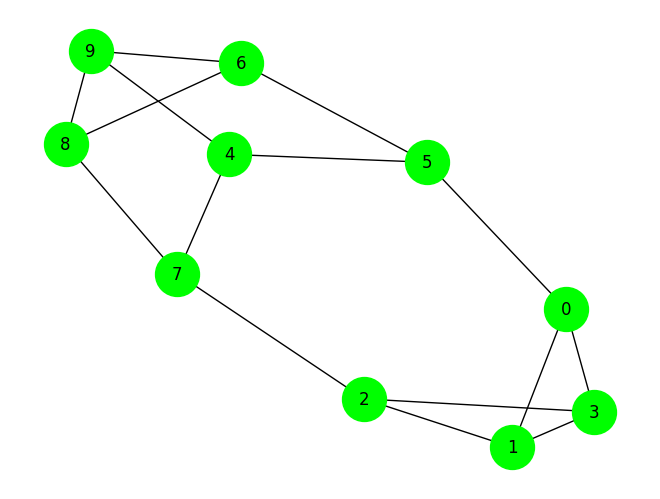

In [8]:
sm = SATMapper()
remapped_g, sat_map, min_swap_layers = sm.remap_graph_with_sat(
    graph=graph, swap_strategy=swap_strategy
)

print("Map from old to new nodes: ", sat_map)
print("Min SWAP layers:", min_swap_layers)
nx.draw(
    remapped_g,
    with_labels=True,
    node_size=1000,
    node_color="lime",
    pos=nx.spring_layout(remapped_g, seed=seed),
)

#### Construct a cost Hamiltonian from the remapped graph
As explained in Step 1, the repository includes utils to map from a graph to a pauli list for the Max-Cut setting.

In [9]:
remapped_max_cut_paulis = build_max_cut_paulis(remapped_g)
# define a qiskit SparsePauliOp from the list of paulis
remapped_cost_operator = SparsePauliOp.from_list(remapped_max_cut_paulis)
print(remapped_cost_operator)

SparsePauliOp(['ZIIIIZIIII', 'ZZIIIIIIII', 'ZIIZIIIIII', 'IIZIIZIIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IZIZIIIIII', 'IIIIZIIIIZ', 'IIZIIIIZII', 'IZZIIIIIII', 'IIIIIIZIZI', 'IIIIIIZZII', 'IIIIIIZIIZ', 'IIIIIIIIZZ', 'IIIIIIIZZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### Build a QAOA circuit with the SWAP strategy and the SAT mapping

In [10]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector


def make_meas_map(circuit: QuantumCircuit) -> dict:
    """Return a mapping from qubit index (the key) to classical bit (the value).

    This allows us to account for the swapping order introduced by the SwapStrategy.
    """
    creg = circuit.cregs[0]
    qreg = circuit.qregs[0]

    meas_map = {}
    for inst in circuit.data:
        if inst.operation.name == "measure":
            meas_map[qreg.index(inst.qubits[0])] = creg.index(inst.clbits[0])

    return meas_map


def apply_swap_strategy(
    circuit: QuantumCircuit,
    swap_strategy: SwapStrategy,
    edge_coloring: dict[tuple[int, int], int] | None = None,
) -> QuantumCircuit:
    """Transpile with a SWAP strategy.

    Returns:
        A quantum circuit transpiled with the given swap strategy.
    """

    pm_pre = PassManager(
        [
            FindCommutingPauliEvolutions(),
            Commuting2qGateRouter(
                swap_strategy,
                edge_coloring,
            ),
        ]
    )
    return pm_pre.run(circuit)


def apply_qaoa_layers(  # pylint: disable=too-many-arguments,too-many-locals
    cost_layer: QuantumCircuit,
    meas_map: dict,
    num_layers: int,
    gamma: list[float] | ParameterVector = None,
    beta: list[float] | ParameterVector = None,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Applies QAOA layers to construct circuit.

    First, the initial state is applied. If `initial_state` is None we begin in the
    initial superposition state. Next, we alternate between layers of the cot operator
    and the mixer. The cost operator is alternatively applied in order and in reverse
    instruction order. This allows us to apply the swap-strategy on odd `p` layers
    and undo the swap strategy on even `p` layers.
    """

    num_qubits = cost_layer.num_qubits
    new_circuit = QuantumCircuit(num_qubits, num_qubits)

    if initial_state is not None:
        new_circuit.append(initial_state, range(num_qubits))
    else:
        # all h state by default
        new_circuit.h(range(num_qubits))

    if gamma is None or beta is None:
        gamma = ParameterVector("γ", num_layers)
        if mixer is None or mixer.num_parameters == 0:
            beta = ParameterVector("β", num_layers)
        else:
            beta = ParameterVector("β", num_layers * mixer.num_parameters)

    if mixer is not None:
        mixer_layer = mixer
    else:
        mixer_layer = QuantumCircuit(num_qubits)
        mixer_layer.rx(-2 * beta[0], range(num_qubits))

    for layer in range(num_layers):
        bind_dict = {cost_layer.parameters[0]: gamma[layer]}
        cost_layer_ = cost_layer.assign_parameters(bind_dict)
        bind_dict = {
            mixer_layer.parameters[i]: beta[layer + i] for i in range(mixer_layer.num_parameters)
        }
        layer_mixer = mixer_layer.assign_parameters(bind_dict)

        if layer % 2 == 0:
            new_circuit.append(cost_layer_, range(num_qubits))
        else:
            new_circuit.append(cost_layer_.reverse_ops(), range(num_qubits))

        new_circuit.append(layer_mixer, range(num_qubits))

    for qidx, cidx in meas_map.items():
        new_circuit.measure(qidx, cidx)

    return new_circuit


def create_qaoa_swap_circuit(  # pylint: disable=too-many-arguments
    cost_operator: SparsePauliOp,
    swap_strategy: SwapStrategy,
    edge_coloring: dict = None,
    theta: list[float] = None,
    qaoa_layers: int = 1,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Create the circuit for QAOA.

    Notes: This circuit construction for QAOA works for quadratic terms in `Z` and will be
    extended to first-order terms in `Z`. Higher-orders are not supported.

    Args:
        cost_operator: the cost operator.
        swap_strategy: selected swap strategy
        edge_coloring: A coloring of edges that should correspond to the coupling
            map of the hardware. It defines the order in which we apply the Rzz
            gates. This allows us to choose an ordering such that `Rzz` gates will
            immediately precede SWAP gates to leverage CNOT cancellation.
        theta: The QAOA angles.
        qaoa_layers: The number of layers of the cost-operator and the mixer operator.
        initial_state: The initial state on which we apply layers of cost-operator
            and mixer.
        mixer: The QAOA mixer. It will be applied as is onto the QAOA circuit. Therefore,
            its output must have the same ordering of qubits as its input.
    """

    num_qubits = cost_operator.num_qubits

    if theta is not None:
        gamma = theta[: len(theta) // 2]
        beta = theta[len(theta) // 2 :]
        qaoa_layers = len(theta) // 2
    else:
        gamma = beta = None

    # First, create the ansatz of 1 layer of QAOA without mixer
    cost_layer = QAOAAnsatz(
        cost_operator,
        reps=1,
        initial_state=QuantumCircuit(num_qubits),
        mixer_operator=QuantumCircuit(num_qubits),
    ).decompose()

    # This will allow us to recover the permutation of the measurements that the swap introduce.
    cost_layer.measure_all()

    # Now, apply the swap strategy for commuting pauli evolution gates
    cost_layer = apply_swap_strategy(cost_layer, swap_strategy, edge_coloring)

    # Compute the measurement map (qubit to classical bit).
    # we will apply this for qaoa_layers % 2 == 1.
    if qaoa_layers % 2 == 1:
        meas_map = make_meas_map(cost_layer)
    else:
        meas_map = {idx: idx for idx in range(num_qubits)}

    cost_layer.remove_final_measurements()

    # Finally, introduce the mixer circuit and add measurements following measurement map
    circuit = apply_qaoa_layers(
        cost_layer, meas_map, qaoa_layers, gamma, beta, initial_state, mixer
    )

    return circuit

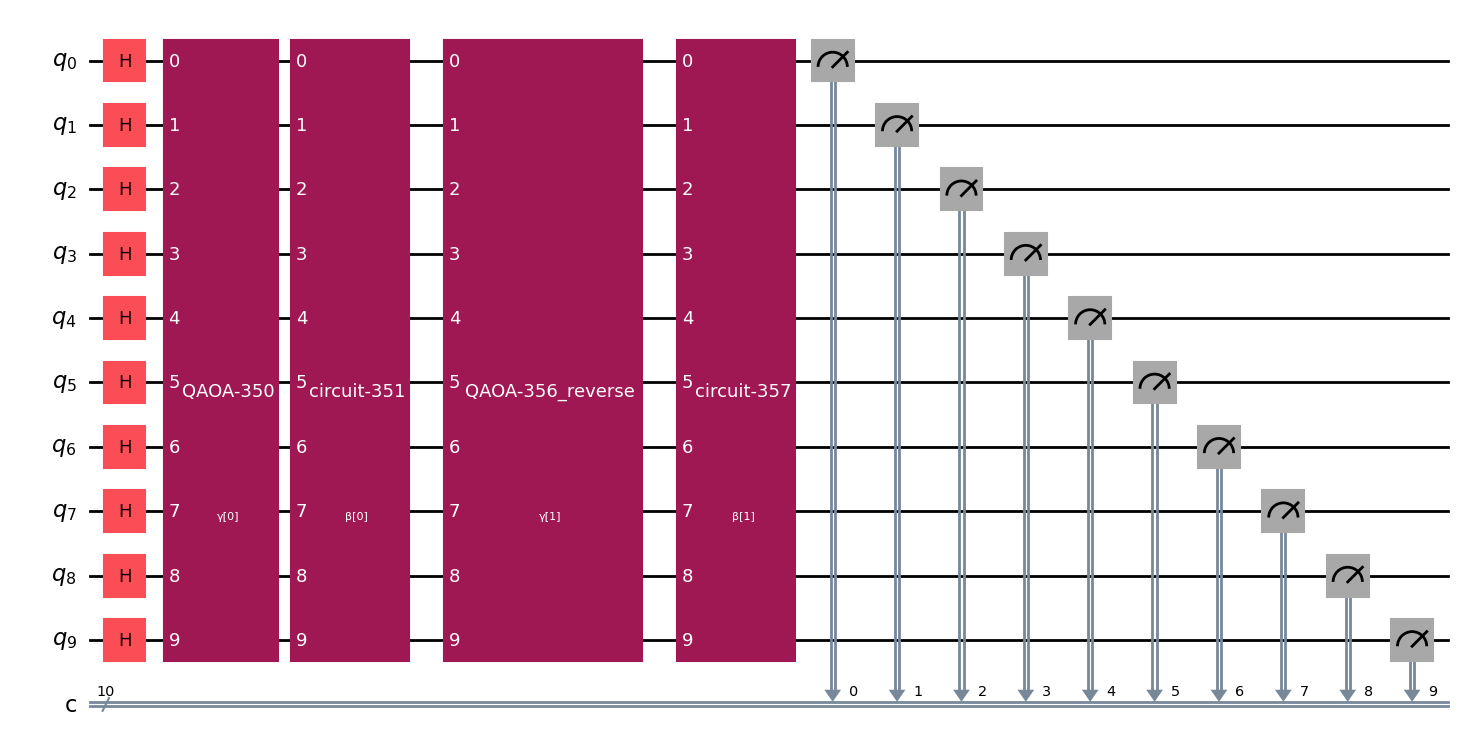

In [11]:
# We define the edge_coloring map so that RZZGates are positioned next to SWAP gates to exploit CX cancellations
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(remapped_cost_operator.num_qubits)}

qaoa_circ = create_qaoa_swap_circuit(
    remapped_cost_operator, swap_strategy, edge_coloring, qaoa_layers=2
)
qaoa_circ.draw(output="mpl")

### 2.3 Transpile the circuit
#### Choose backend

In [12]:
# SIMULATED FAKE BACKEND --> BackendSampler
from qiskit.providers.fake_provider.backends_v1 import Fake20QV1
from qiskit.primitives import BackendSampler

backend = Fake20QV1()
sampler = BackendSampler(backend=backend, skip_transpilation=True)

/Users/matsuo/envs/qeet/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/matsuo/envs/qeet/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


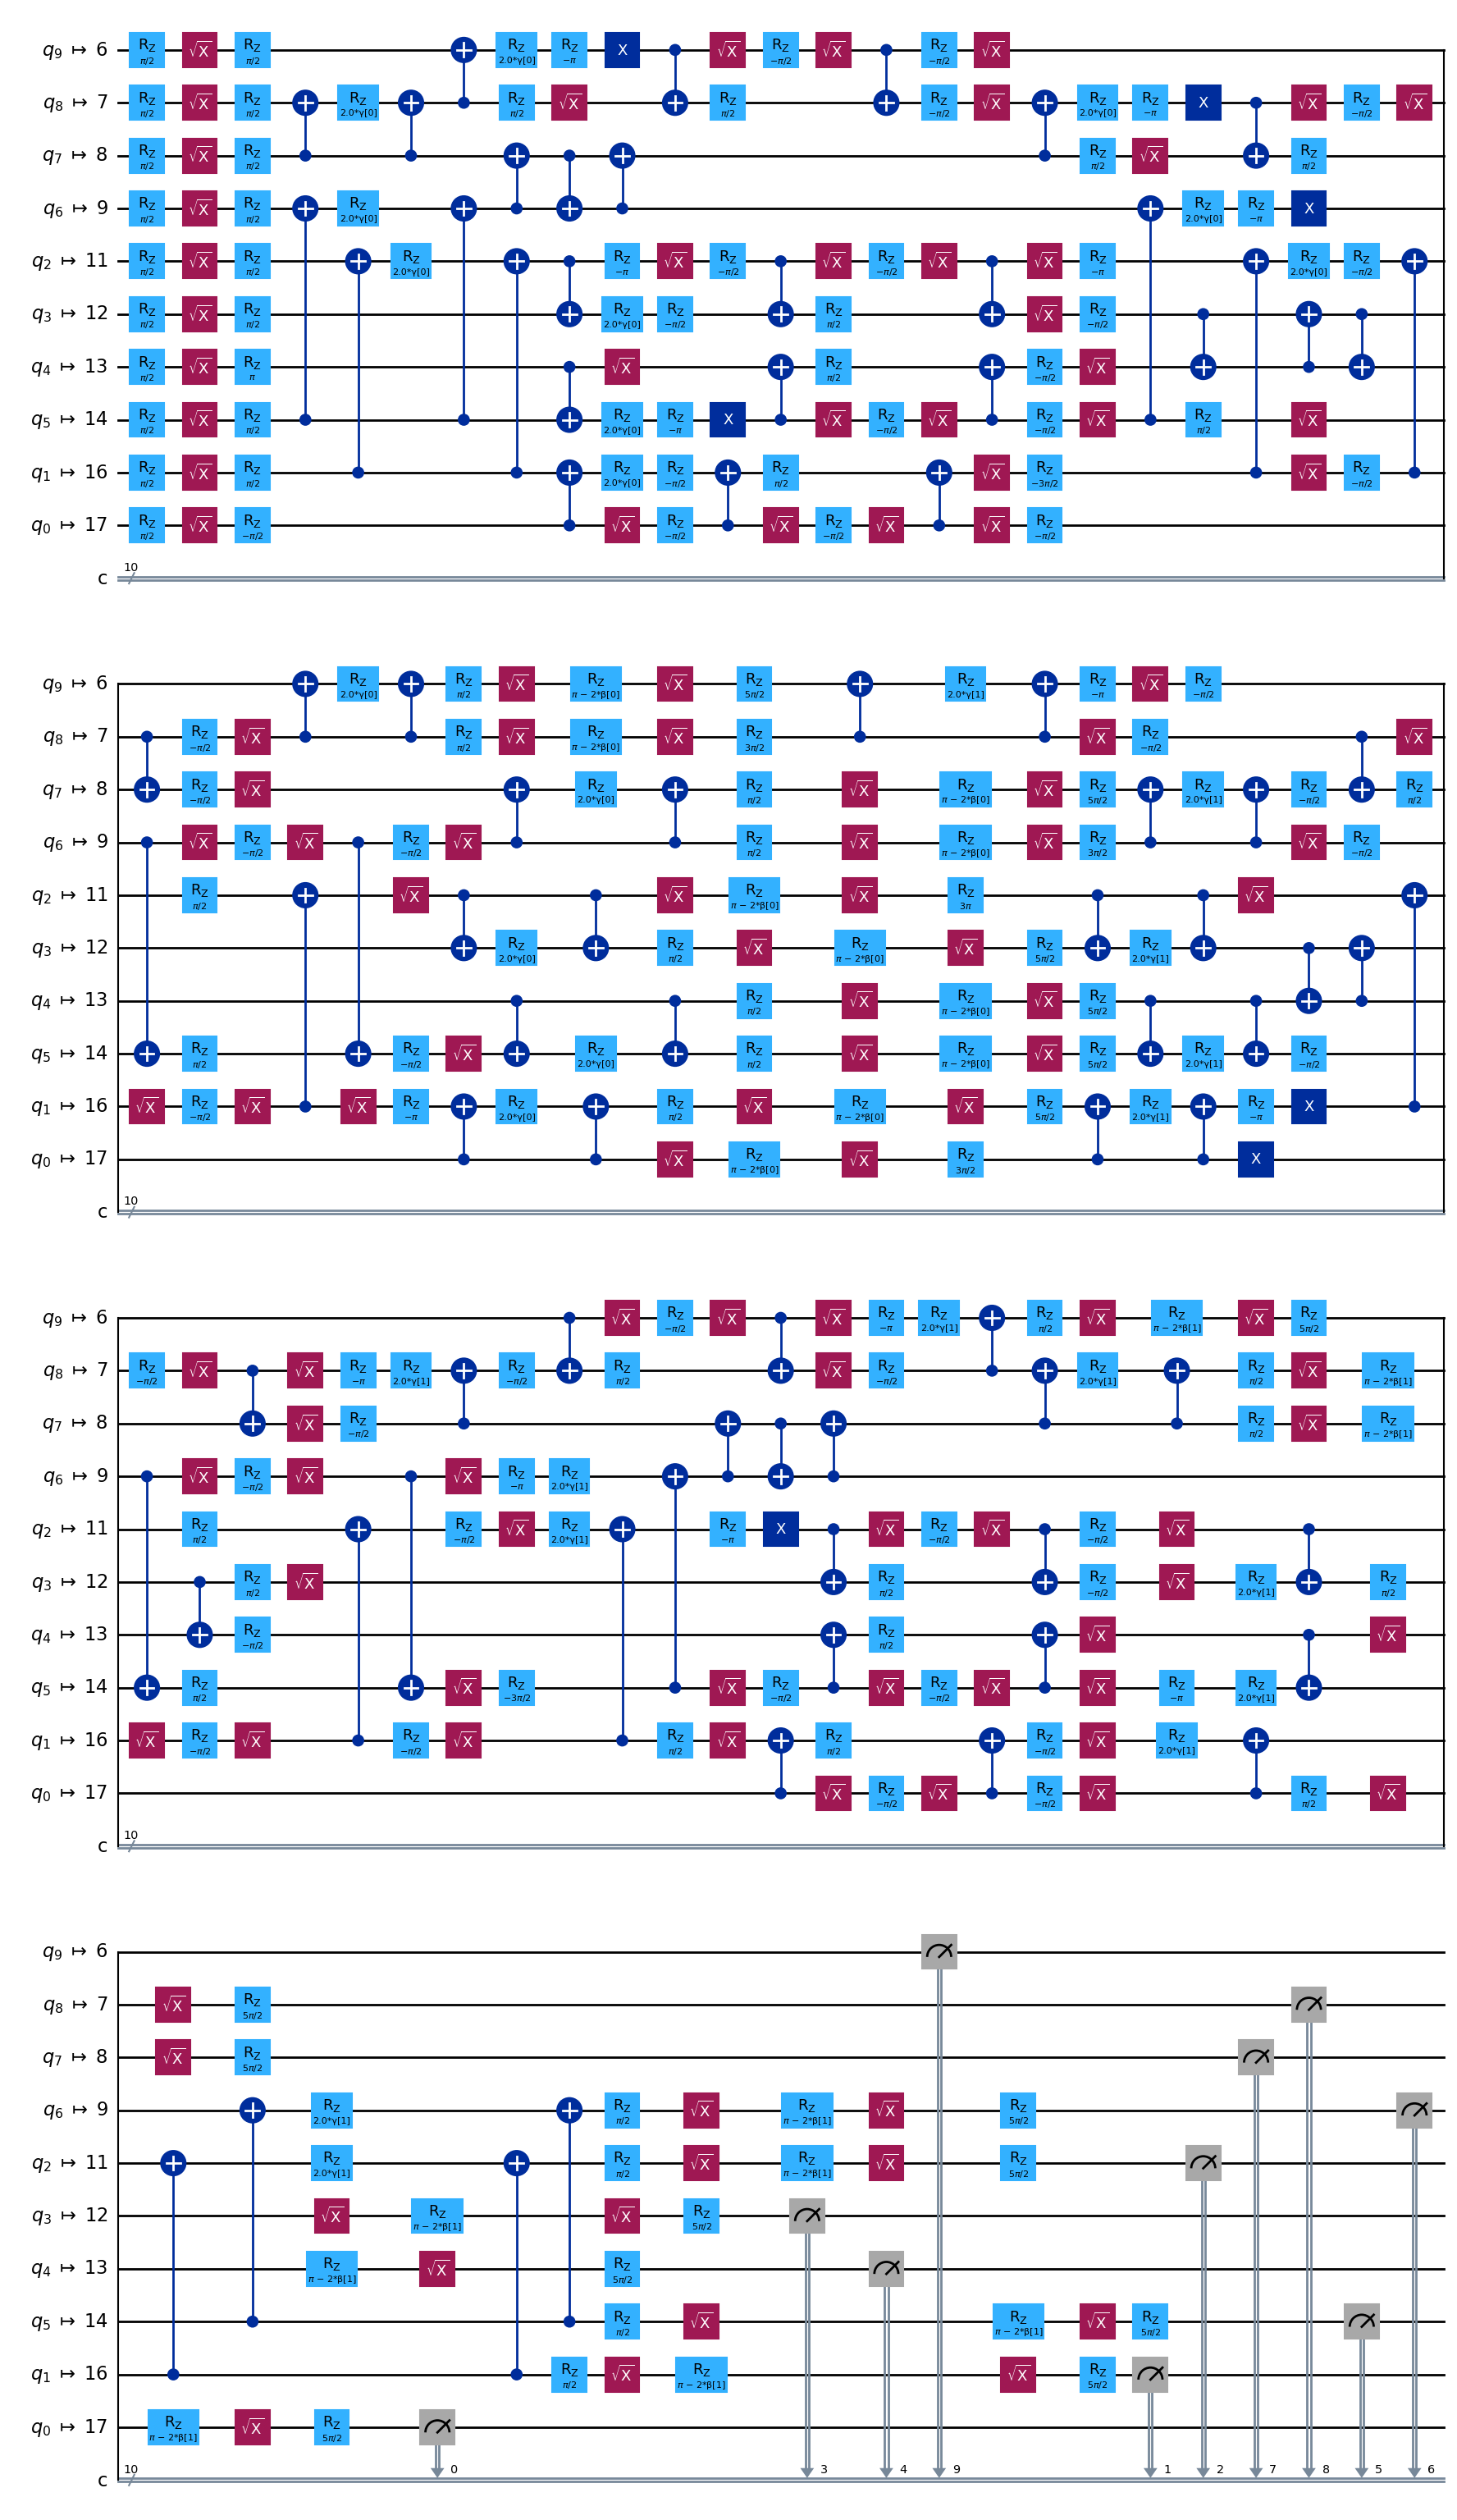

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


basis_gates = ["rz", "sx", "x", "cx"]

pass_manager = generate_preset_pass_manager(
    backend=backend, optimization_level=3, basis_gates=basis_gates
)

transpiled_qaoa_circ = pass_manager.run(qaoa_circ)
transpiled_qaoa_circ.draw(output="mpl", idle_wires=False)

## Step3: Executing the optimized circuit using Qiskit Runtime primitives.
### 3.1 Define a cost function
The QAOA cost function using the Sampler requires the manual computation of the expectation values from the measurement results. For this means, we use the `` helper function.

In [14]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

In [17]:
from collections.abc import Callable, Iterable

def qaoa_sampler_cost_fun(params, ansatz, hamiltonian, sampler, aggregation=None):
    """Standard sampler-based QAOA cost function to be plugged into optimizer routines.

    Args:
        params (np.ndarray): Parameters for the ansatz.
        ansatz (QuantumCircuit): Ansatz circuit.
        hamiltonian (SparsePauliOp): Hamiltonian to be minimized.
        sampler (QAOASampler): Sampler to be used.
        aggregation (Callable | float | None): Aggregation function to be applied to
            the sampled results. If None, the sum of the expectation values is returned.
            If float, the CVaR with the given alpha is used.
    """
    job = sampler.run(ansatz, params)
    sampler_result = job.result()
    sampled = sampler_result.quasi_dists[0]

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    # If aggregation is None, return the sum of the expectation values.
    # If aggregation is a float, return the CVaR with the given alpha.
    # Otherwise, use the aggregation function.
    if aggregation is None:
        result = sum(probability * value for probability, value in evaluated.values())
    elif isinstance(aggregation, float):
        cvar_aggregation = _get_cvar_aggregation(aggregation)
        result = cvar_aggregation(evaluated.values())
    else:
        result = aggregation(evaluated.values())

    return result


def _get_cvar_aggregation(alpha: float | None) -> Callable:
    """Return the CVaR aggregation function with the given alpha.

    Args:
        alpha (float | None): Alpha value for the CVaR aggregation. If None, 1 is used
            by default.
    Raises:
        ValueError: If alpha is not in [0, 1].
    """
    if alpha is None:
        alpha = 1
    elif not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1], but {alpha} was given.")

    def cvar_aggregation(objective_dict: Iterable[tuple[float, float]]) -> float:
        """Return the CVaR of the given measurements.
        Args:
            objective_dict (Iterable[tuple[float, float]]): An iterable of tuples containing
                the measured bit string and the objective value based on the bit string.

        """
        sorted_measurements = sorted(objective_dict, key=lambda x: x[1])
        # accumulate the probabilities until alpha is reached
        accumulated_percent = 0.0
        cvar = 0.0
        for probability, value in sorted_measurements:
            cvar += value * min(probability, alpha - accumulated_percent)
            accumulated_percent += probability
            if accumulated_percent >= alpha:
                break
        return cvar / alpha

    return cvar_aggregation

In [18]:
# TQA initialization parameters
dt = 0.75
p = 2  # 2 qaoa layers
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))
print(init_params)

[0.8125 0.4375 0.1875 0.5625]


In [19]:
from scipy.optimize import minimize

result = minimize(
    qaoa_sampler_cost_fun,
    init_params,
    args=(transpiled_qaoa_circ, remapped_cost_operator, sampler, 0.2),
    method="COBYLA",
)
print(result)

/Users/matsuo/envs/qeet/lib/python3.11/site-packages/qiskit/providers/fake_provider/fake_backend.py:558: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)
/Users/matsuo/envs/qeet/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -10.474609375000002
       x: [ 6.341e-01  3.545e-01  2.336e-01  4.823e-01]
    nfev: 50
   maxcv: 0.0


## Step 4: Post-processing the results and returning them in classical format.
### 4.1 Sample the best result
We can use the best parameters found by the optimization routine to sample the best result from the QAOA circuit.

In [20]:
qc = transpiled_qaoa_circ.assign_parameters(result.x)
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

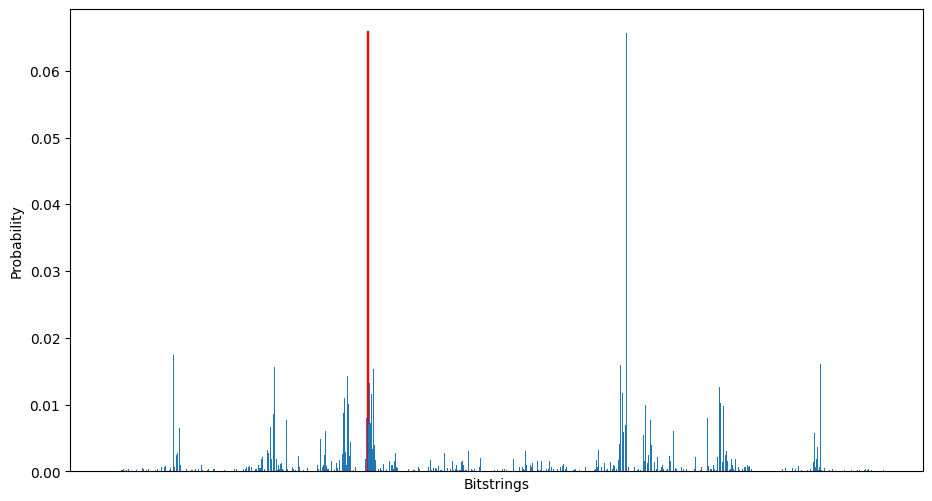

In [21]:
import matplotlib.pyplot as plt

# draw histogram
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.bar(samp_dist.keys(), samp_dist.values())
max_value_bin = max(samp_dist, key=samp_dist.get)
position = list(samp_dist.keys()).index(max_value_bin)
ax.get_children()[position].set_color("red")
plt.ylabel("Probability")
plt.xlabel("Bitstrings")
plt.xticks([])
plt.show()

### 4.2 Visualize the solution
We can visualize the solution using the following function.

Note that the result is for the remapped max-cut problem with Big Endian, so we need to remap it back to the original graph.

In [22]:
def bitfield(n, L):
    # Convert an integer into a bitfield, a list of 0s and 1s
    result = np.binary_repr(n, width=L)
    return [int(digit) for digit in result]


def sample_best_result(sample_distribution, num_qubits):
    evaluated = [
        evaluate_sparse_pauli(bitstr, remapped_cost_operator) for bitstr in sample_distribution
    ]
    k = np.argmin(evaluated)
    x = bitfield(k, num_qubits)
    x.reverse()
    return np.asarray(x)


best_result = sample_best_result(samp_dist, num_qubits)

#  sort nodes in the ascending order
node_view = list(remapped_g.nodes())
sorted_best_result = [best_result[node_view.index(node)] for node in range(num_qubits)]
print(sorted_best_result)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


cut_size: 3
[9] [0, 1, 2, 3, 4, 5, 6, 7, 8]


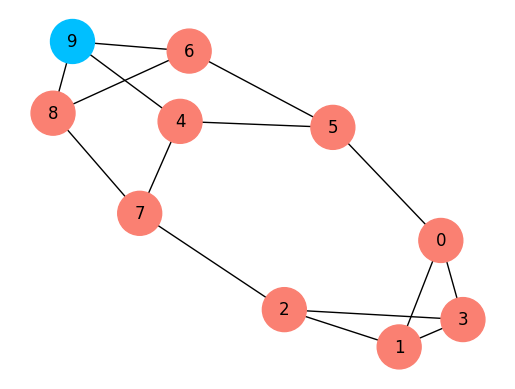

In [23]:
import matplotlib.pyplot as plt


# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["salmon" if i == 0 else "deepskyblue" for i in x]
    pos, default_axes = nx.spring_layout(remapped_g, seed=seed), plt.axes(frameon=True)
    nx.draw(remapped_g, with_labels=True, node_size=1000, node_color=colors, pos=pos)


plot_result(remapped_g, best_result)
cut = [node_view[i] for i, var in enumerate(best_result) if var == 1]
print(f"cut_size: {nx.cut_size(remapped_g, cut)}")
print(sorted(cut), [i for i in range(num_qubits) if i not in cut])